### Подгружаем библиотеки

In [162]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import random
import os
from torch import nn
from torch.nn import functional as F
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (15,3)

In [163]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Подгружаем данные

In [164]:
row_data = pd.read_csv('df.csv', sep=';')
norm_data = pd.read_csv('df_normalized.csv', sep=';')

In [165]:
row_data = row_data.drop(columns=['overview', 'id', 'vote_label'], axis=1)
norm_data = norm_data.drop(columns=['overview', 'id', 'vote_label'], axis=1)

In [166]:
def split_data(data):
    y = data['vote_average']
    X = data.drop(columns=['vote_average'], axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [167]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [168]:
class MinMaxSeries():
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, sample):
        self.min = sample.min()
        self.max = sample.max()

    def transform(self, sample):
        return (sample - self.min) / (self.max - self.min)

    def inverse_transform(self, sample):
        return sample * (self.max - self.min) + self.min

In [169]:
seed_everything(42)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(row_data)

### Архитектура

In [170]:
class PandasDataset(torch.utils.data.Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return {
        'sample': torch.tensor(self.x.iloc[idx,:], dtype=torch.float32),
        'target': torch.tensor(self.y.iloc[idx], dtype=torch.float32)
    }

seed_everything(123456)
train_set = PandasDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, worker_init_fn=42, batch_size=64)

val_set = PandasDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, worker_init_fn=42, batch_size=64)

test_set = PandasDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, worker_init_fn=42, batch_size=64)

In [171]:
def plot_loss(train_loss, val_loss, test_loss):
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(12)

    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)
    ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=1)

    ax1.plot(train_loss)
    ax1.set_title('Train')
    ax1.set_ylabel('MSE')
    ax1.set_xlabel('iter')
    ax1.set_yscale('log')

    ax2.plot(val_loss)
    ax2.set_title('Val')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('iter')

    ax3.plot(test_loss)
    ax3.set_title('Test')
    ax3.set_ylabel('MSE')
    ax3.set_xlabel('iter')

    plt.tight_layout()
    plt.show()

In [172]:
def train(model, data_loader, optimizer, loss_fn, device):

    model.train()
    batch_loss = []

    for batch in tqdm(data_loader, desc='Training'):
        X = batch['sample'].to(device)
        y = batch['target'].to(device)

        y_pred = model(X).squeeze(1)
        loss = loss_fn(y_pred, y).cpu()
        batch_loss.append(loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    return batch_loss

In [173]:
@torch.inference_mode()
def evaluate(model, data_loader, loss_fn, device, data_set, transformer=None):
    model.eval()
    batch_loss = []
    for batch in tqdm(data_loader, desc=f'Evaluate {data_set}'):
        X = batch['sample'].to(device)
        y = batch['target'].to(device)
        pred = model(X).squeeze(1)
        if transformer is not None:
          inv_pred = transformer.inverse_transform(pred.cpu())
          inv_y = transformer.inverse_transform(y.cpu())
          loss = loss_fn(inv_pred, inv_y)
          batch_loss.append(loss)

        else:
          loss = loss_fn(pred, y).cpu()
          batch_loss.append(loss.item())

    return batch_loss

In [174]:
def fit(model, train_loader, val_loader, test_loader, optimizer, loss_fn, num_epochs, device, transformer=None, verbose=True):
    train_loss_history, val_loss_history, test_loss_history = [], [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device, 'validation', transformer)
        test_loss = evaluate(model, test_loader, loss_fn, device, 'test', transformer)

        train_loss_history += train_loss
        val_loss_history += val_loss
        test_loss_history += test_loss

        scheduler.step()

        clear_output()

        rmse = np.sqrt(np.mean(test_loss))
        print(f'Epoch: {epoch+1}')
        print(f'Test RMSE: {rmse}')
        if verbose == True:
            plot_loss(train_loss_history, val_loss_history, test_loss_history)

    return rmse

### Бейзлайн

1. 2 слоя (64 нейронов)
2. Adam
3. lr = 1e-4
3. StepLR(gamma=0.9)

Epoch: 5
Test RMSE: 1.8362472741378089


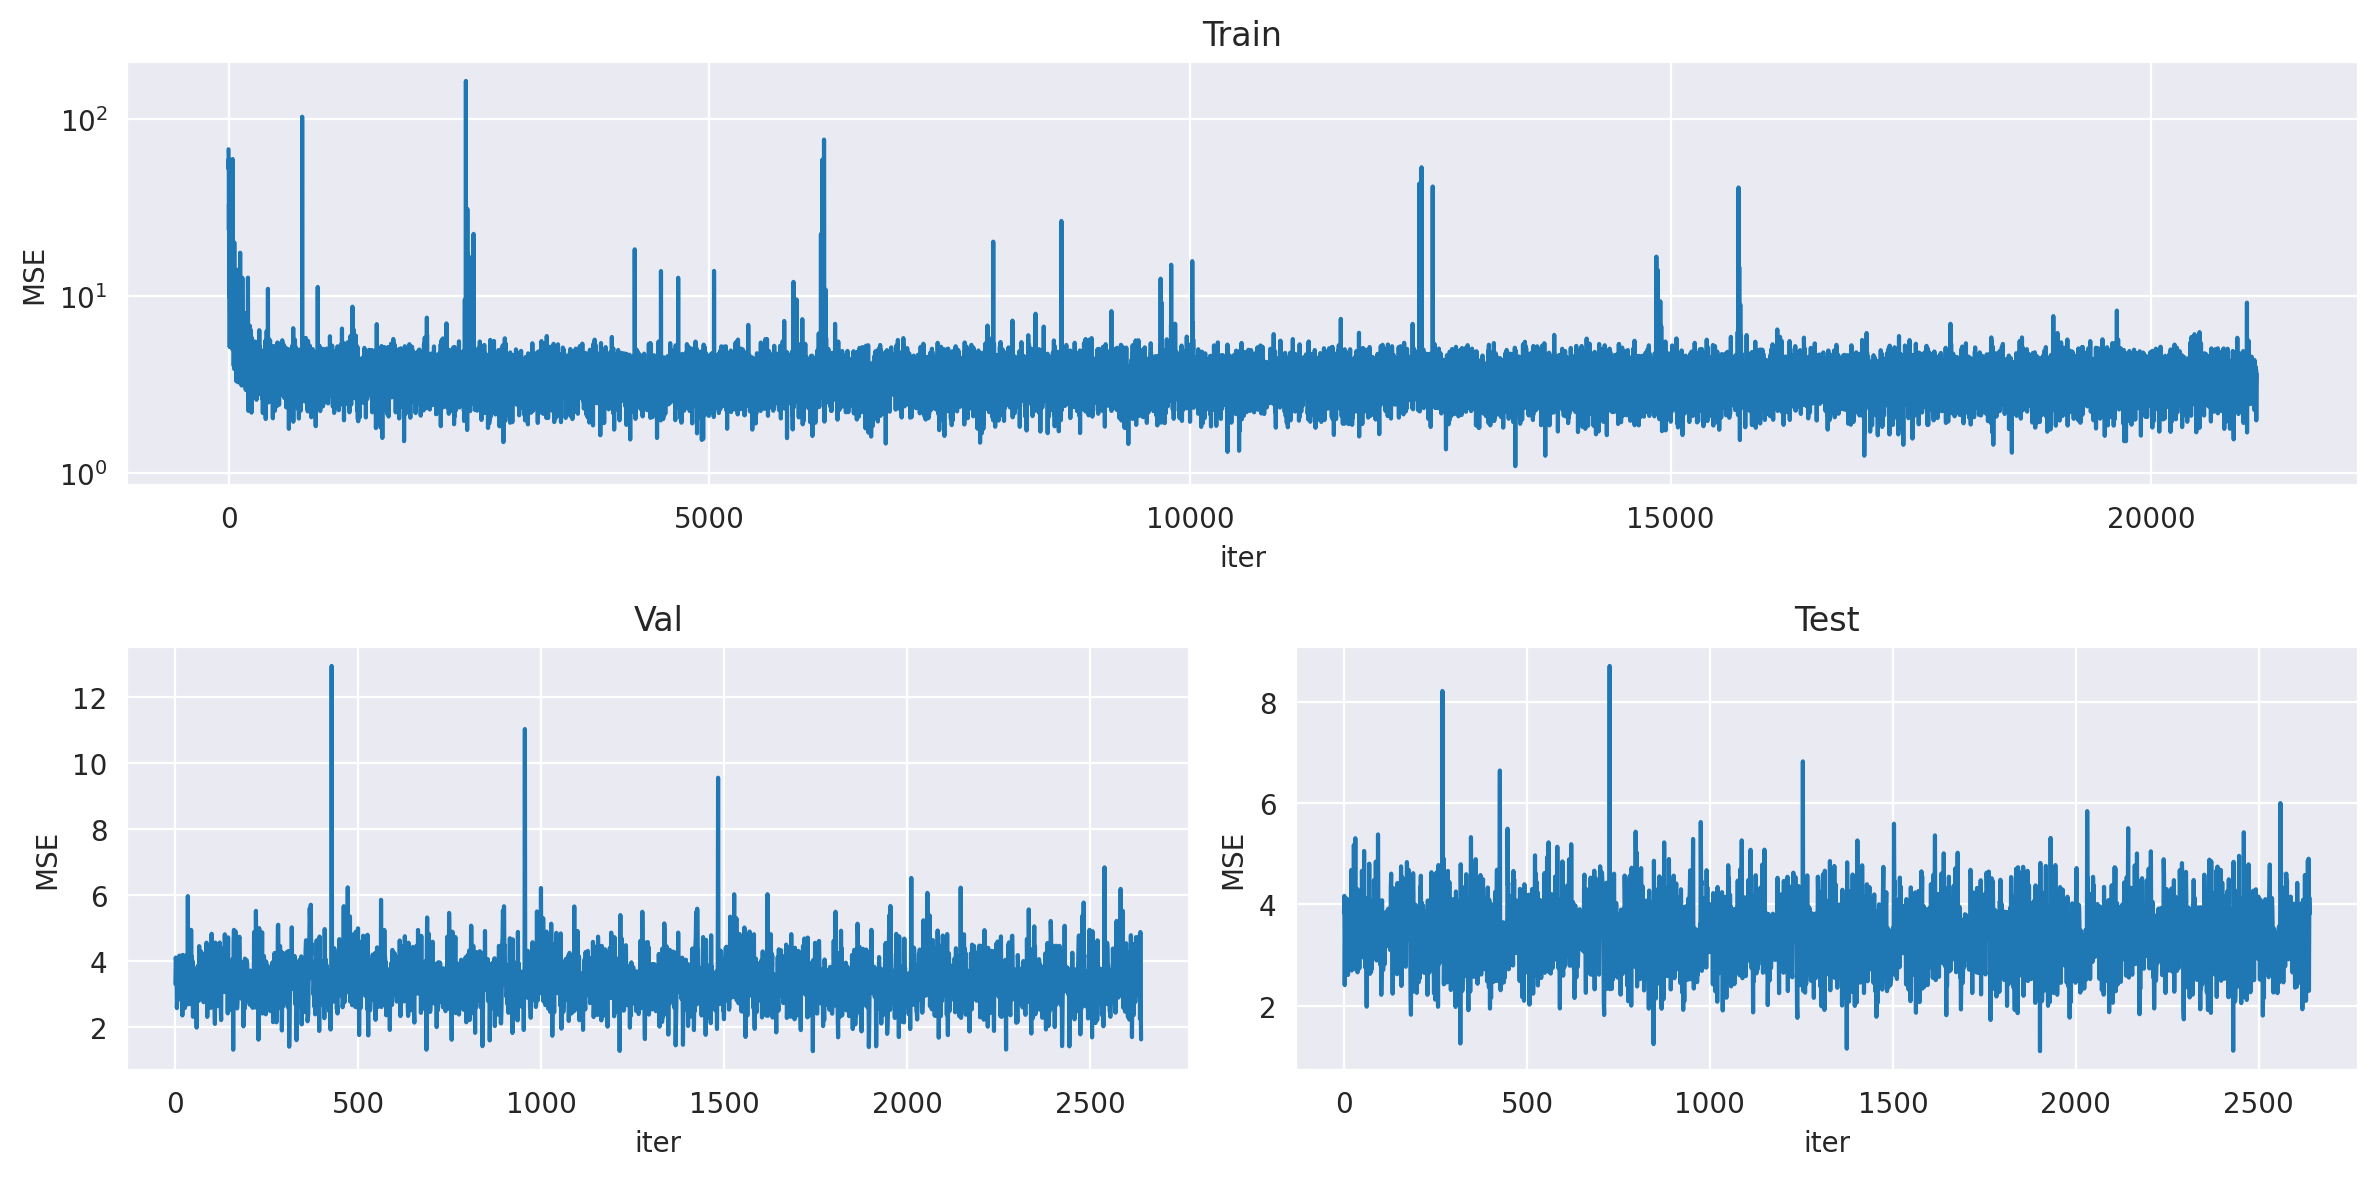

1.8362472741378089

In [175]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device)

#### Нормализованный датасет:
1. 2 слоя (64 нейронов)
2. Adam
3. lr = 1e-4
4. StepLR(gamma=0.9)

In [176]:
seed_everything(42)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(norm_data)

target_scaler = MinMaxSeries()
target_scaler.fit(y_train)

y_train = target_scaler.transform(y_train)
y_val = target_scaler.transform(y_val)
y_test = target_scaler.transform(y_test)

train_set = PandasDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, worker_init_fn=42, batch_size=64)

val_set = PandasDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, worker_init_fn=42, batch_size=64)

test_set = PandasDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, worker_init_fn=42, batch_size=64)

Epoch: 5
Test RMSE: 2.174503803253174


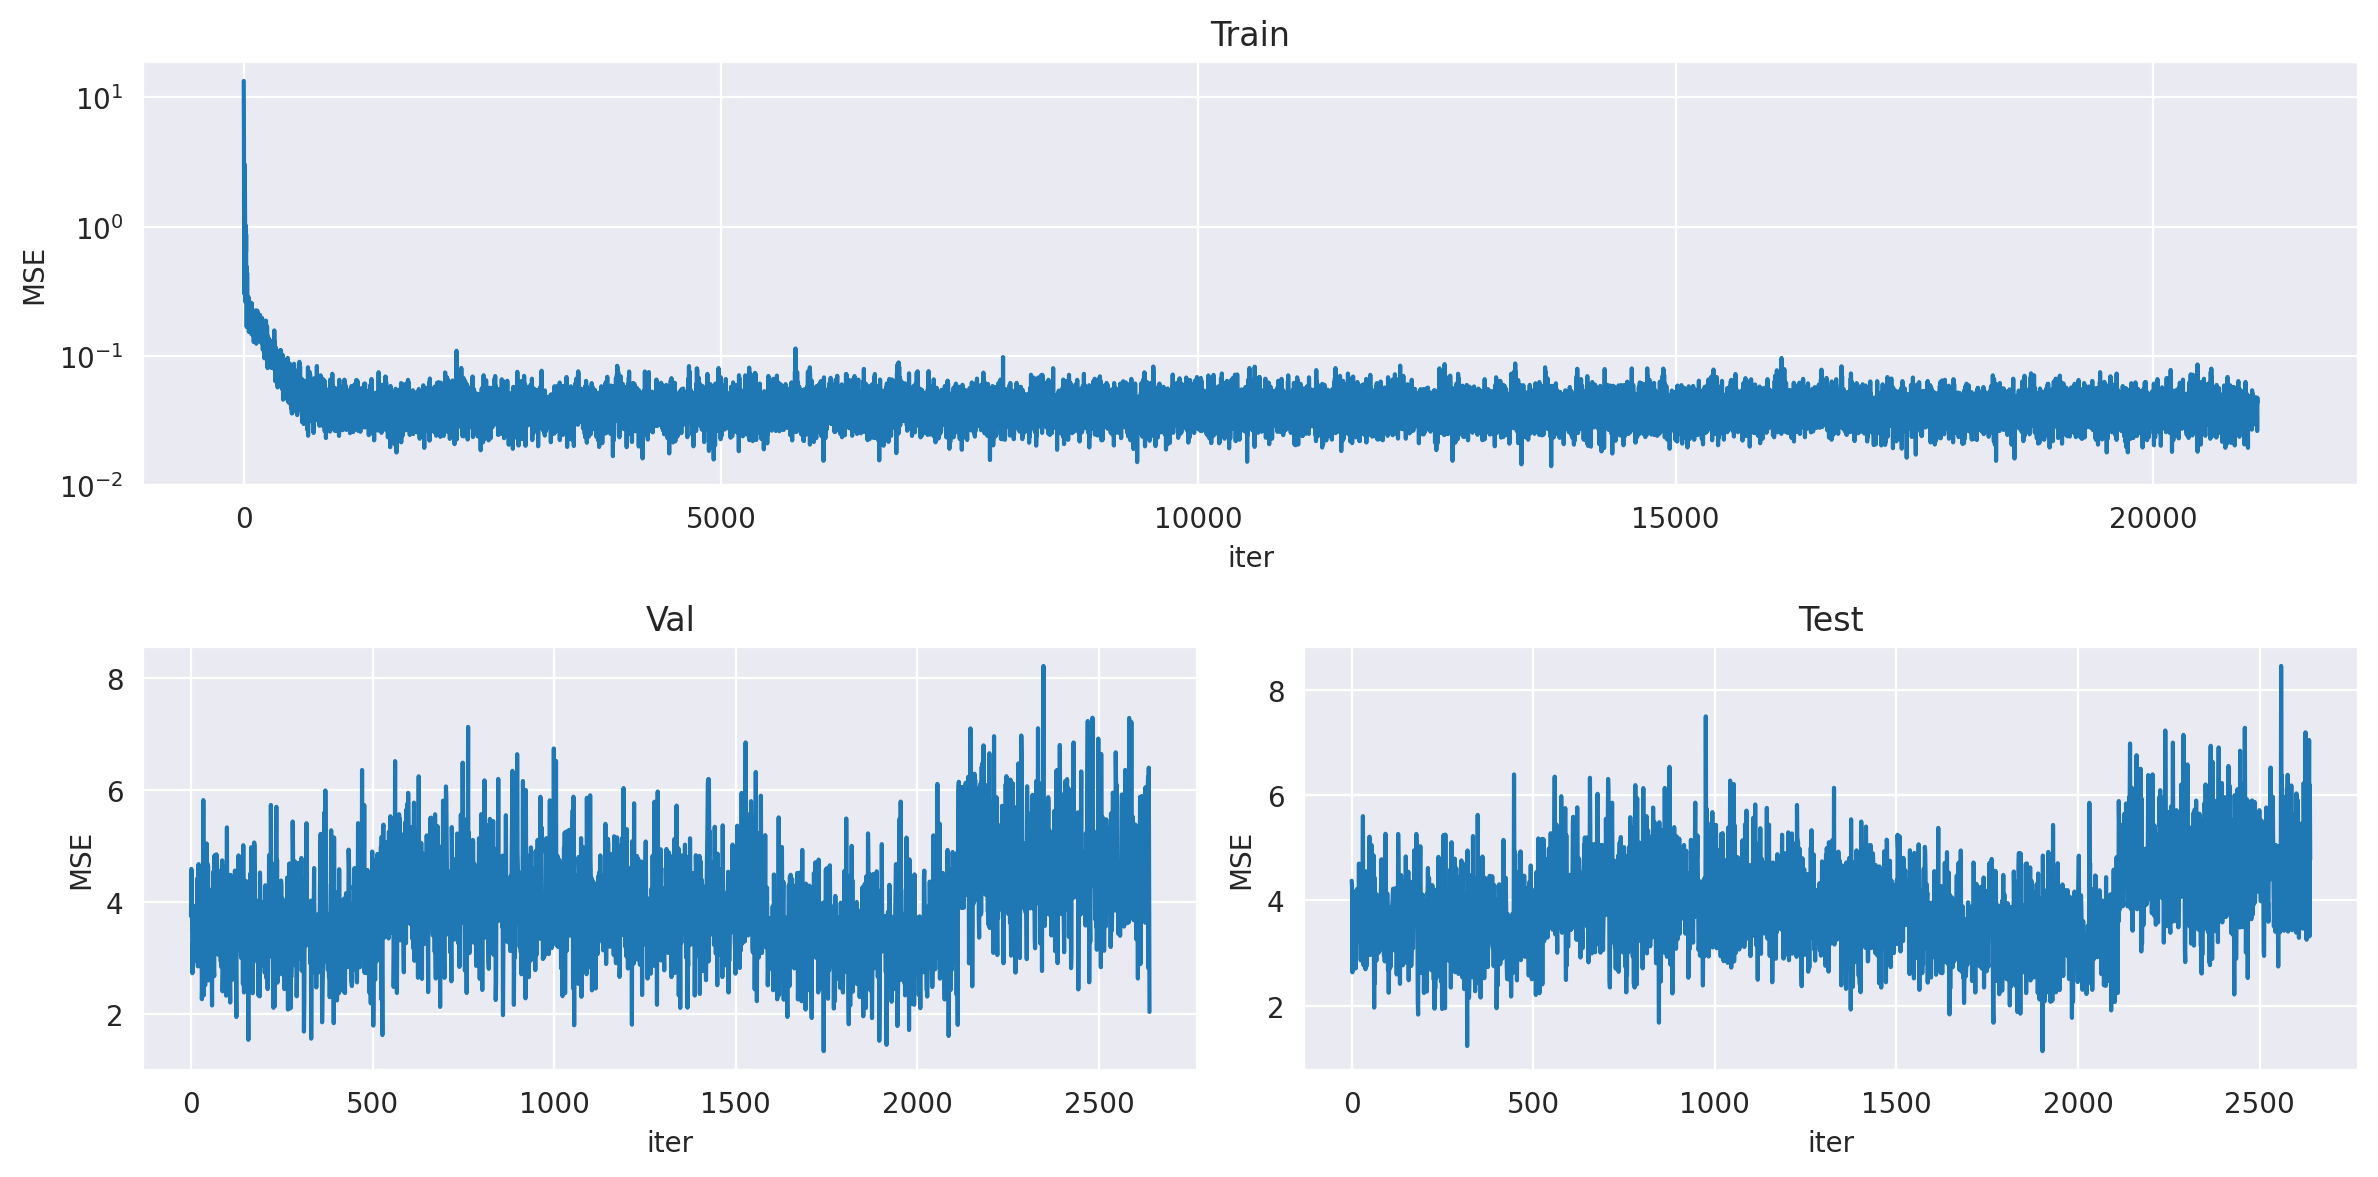

2.1745038

In [177]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Нарастим нейронов:
1. 2 слоя (128 нейронов)
2. Adam
3. lr = 1e-3
4. StepLR(gamma=0.9)

Epoch: 5
Test RMSE: 1.8266292810440063


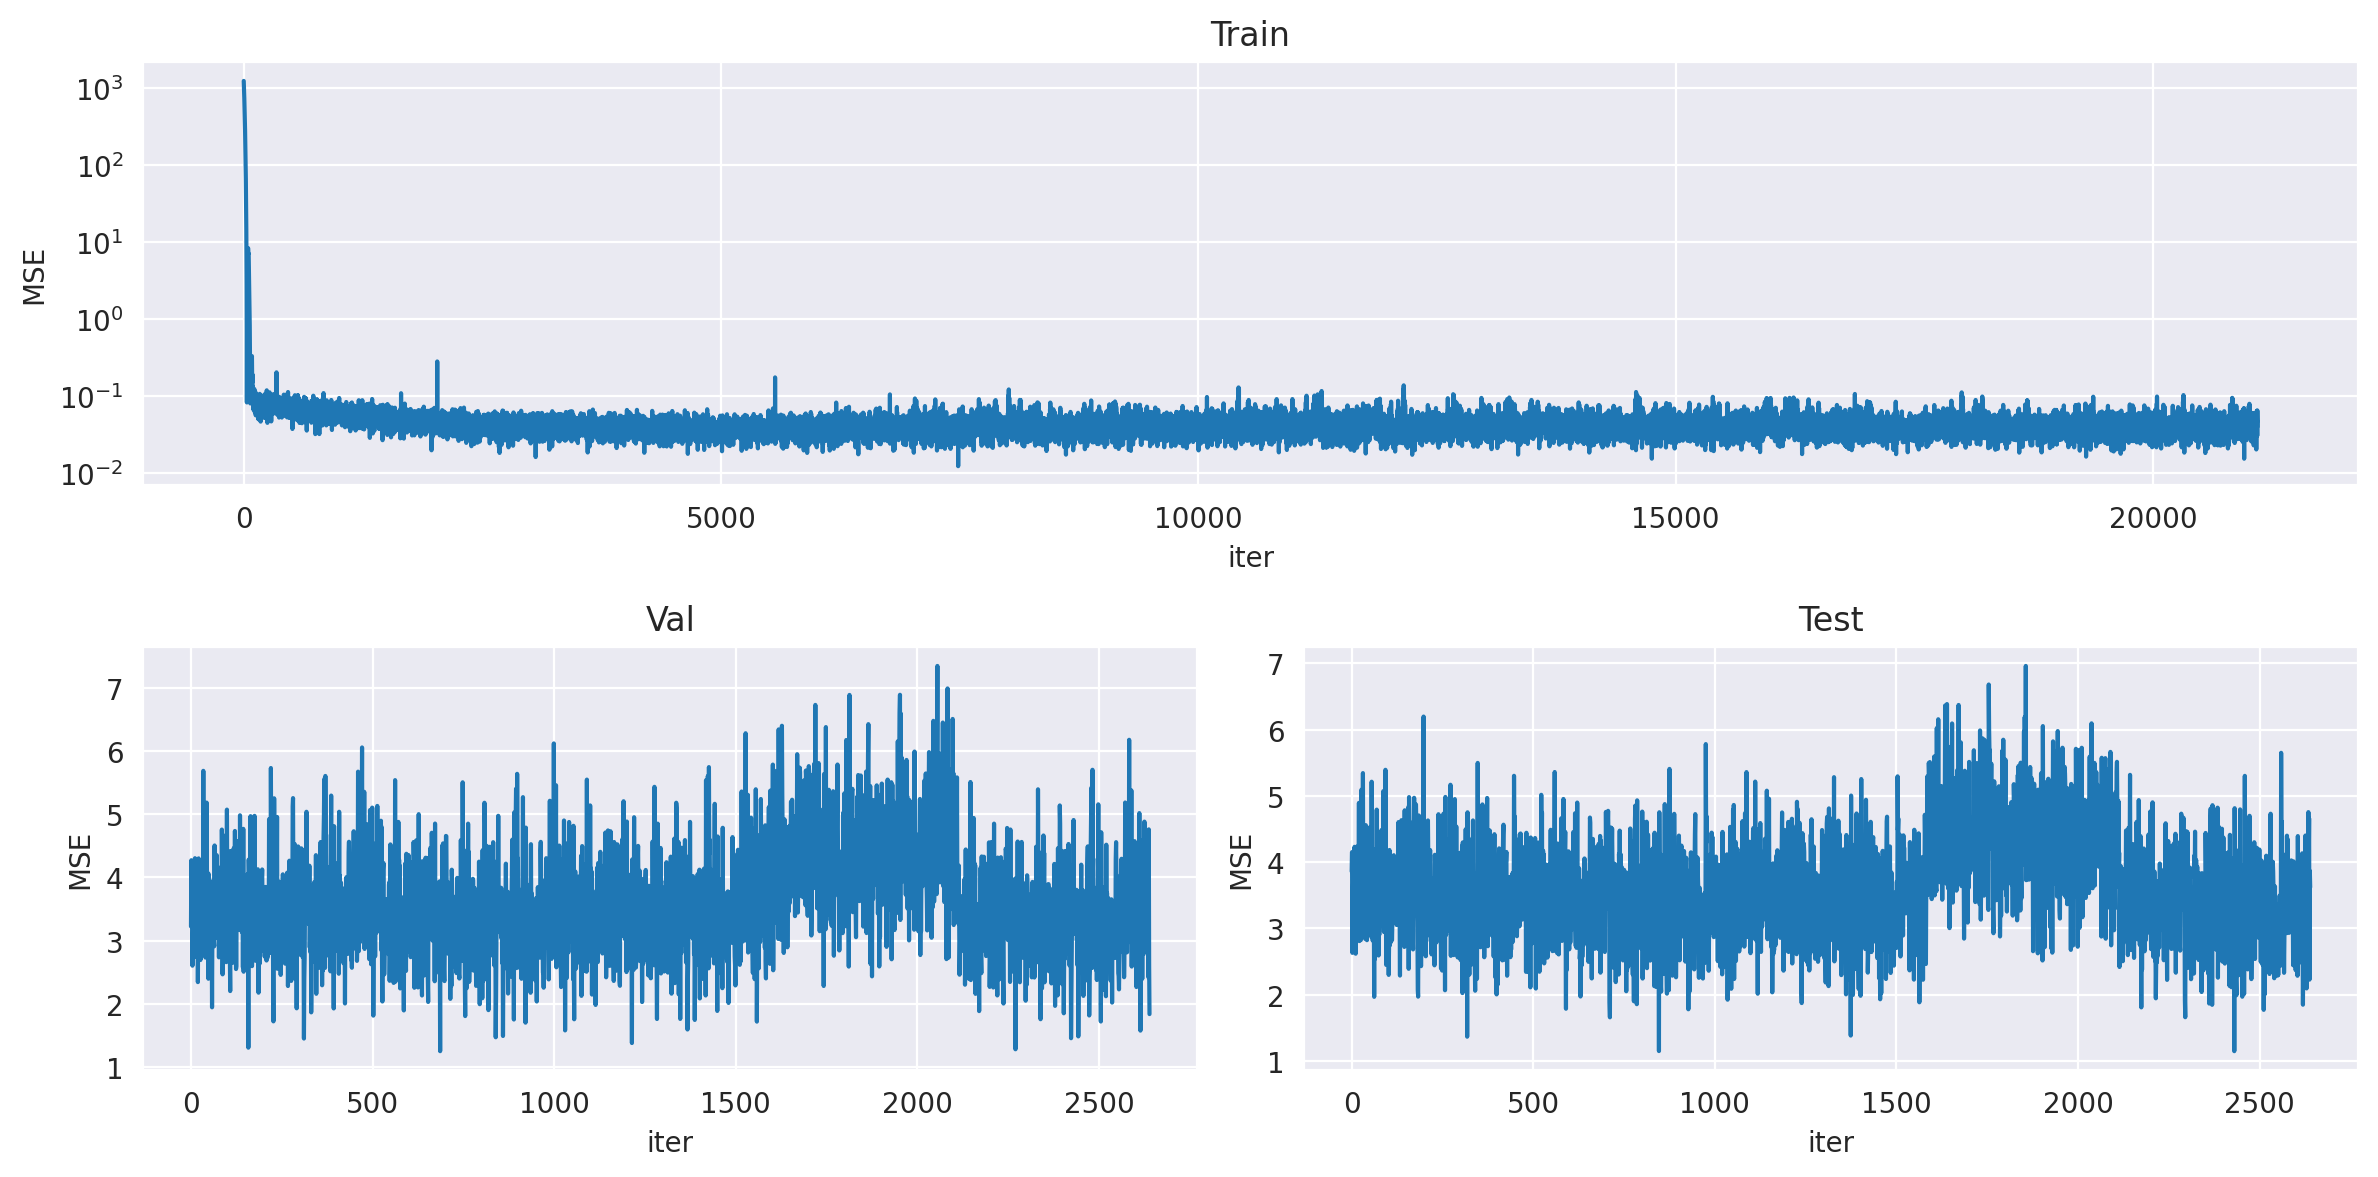

1.8266293

In [178]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Поставим CosineAnnealingLR:
1. 2 слоя (128 нейронов)
2. Adam
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.879866361618042


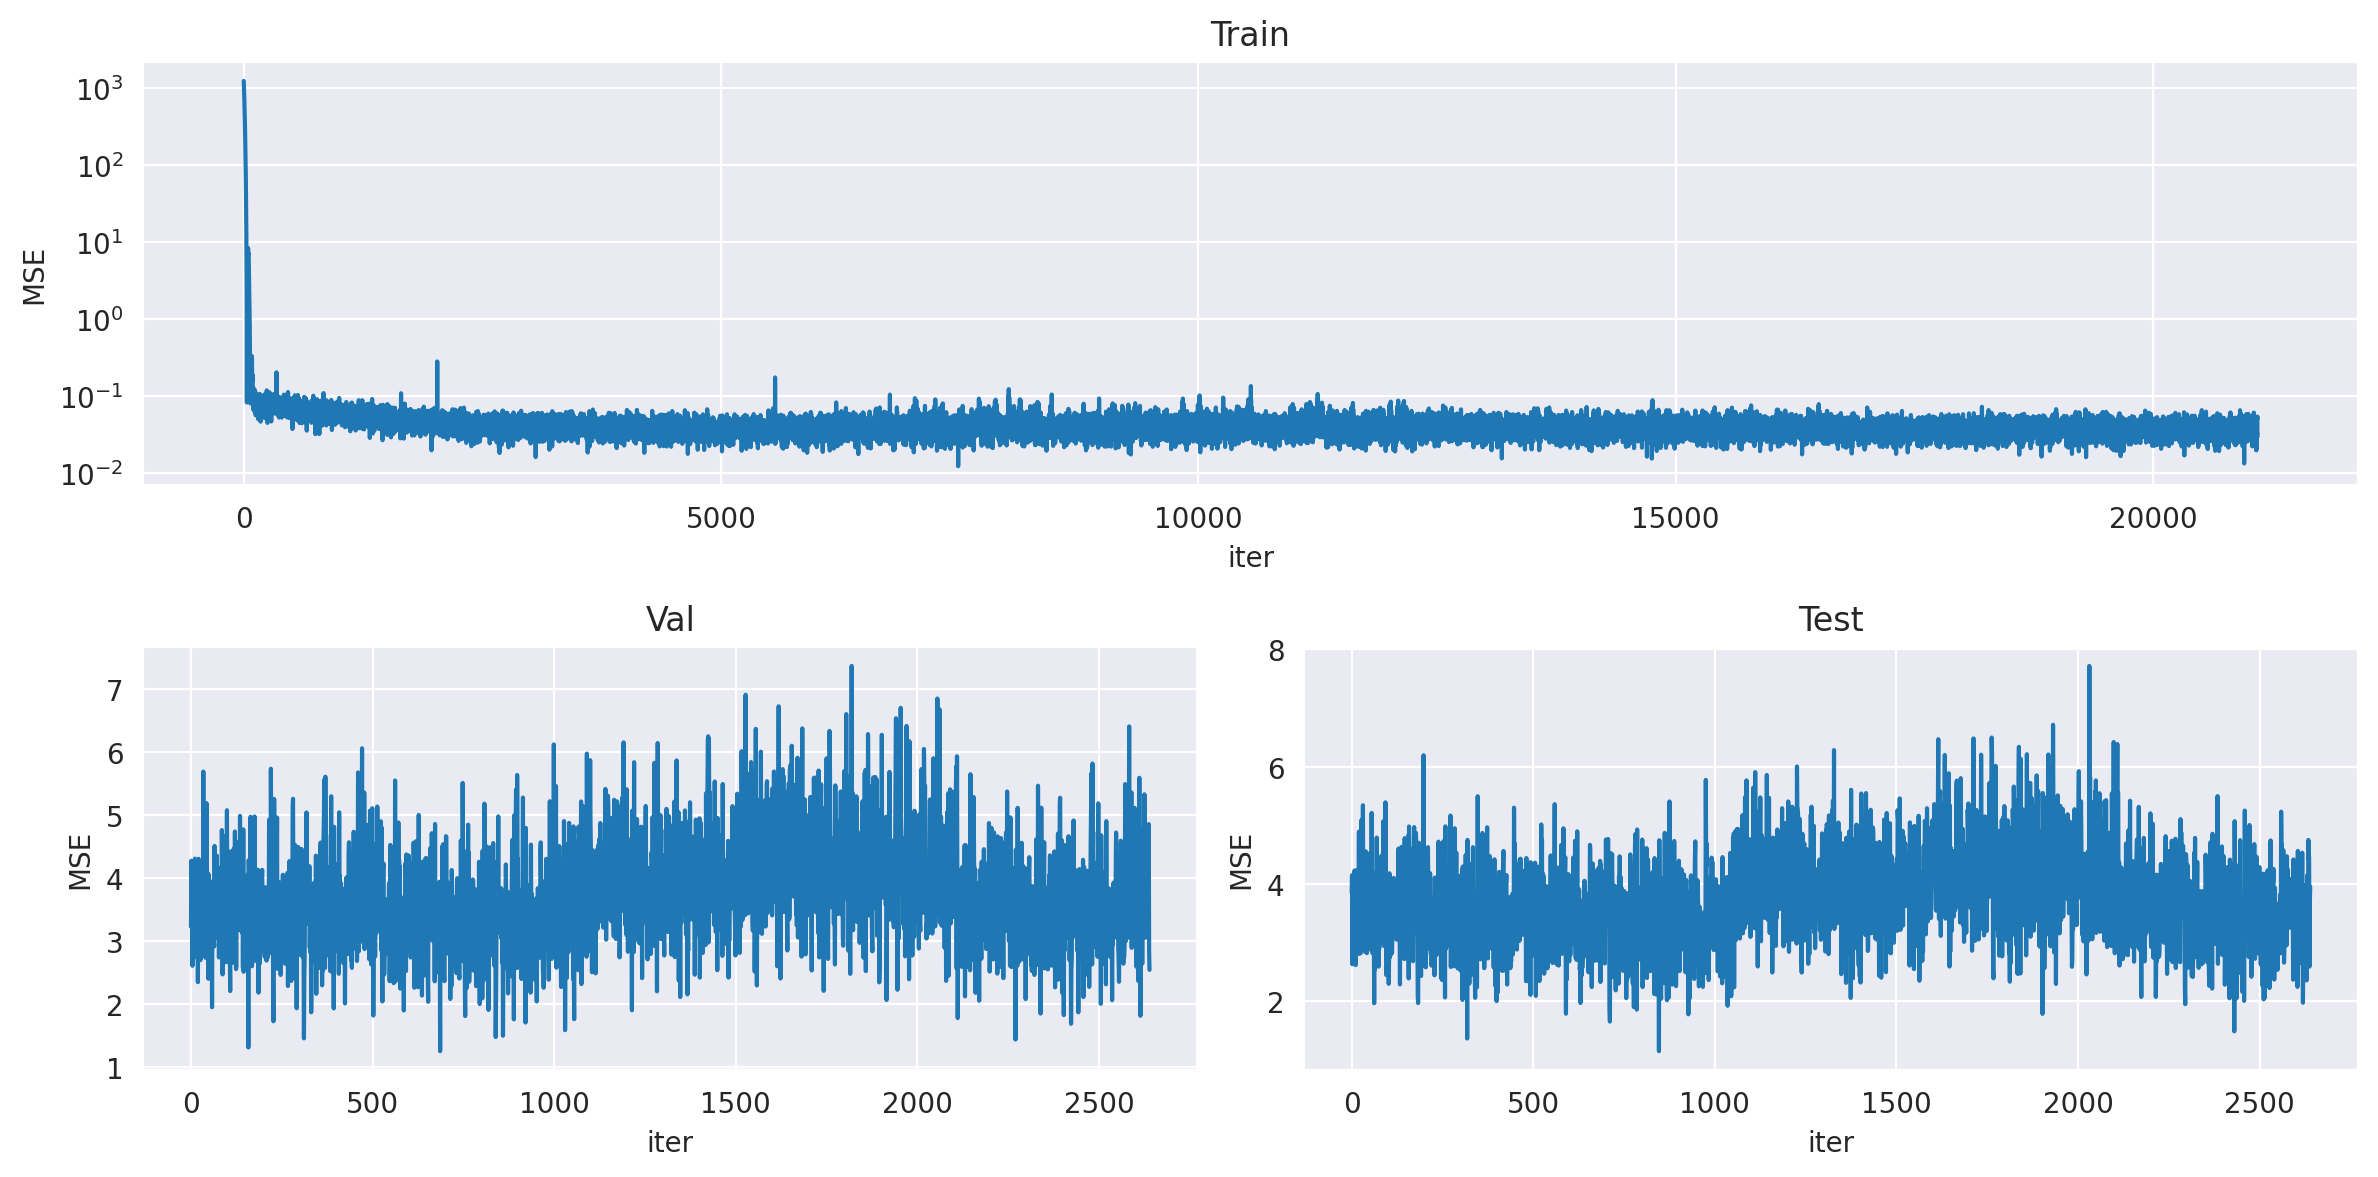

1.8798664

In [179]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Поставим AdamW:
1. 2 слоя (128 нейронов)
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.8806179761886597


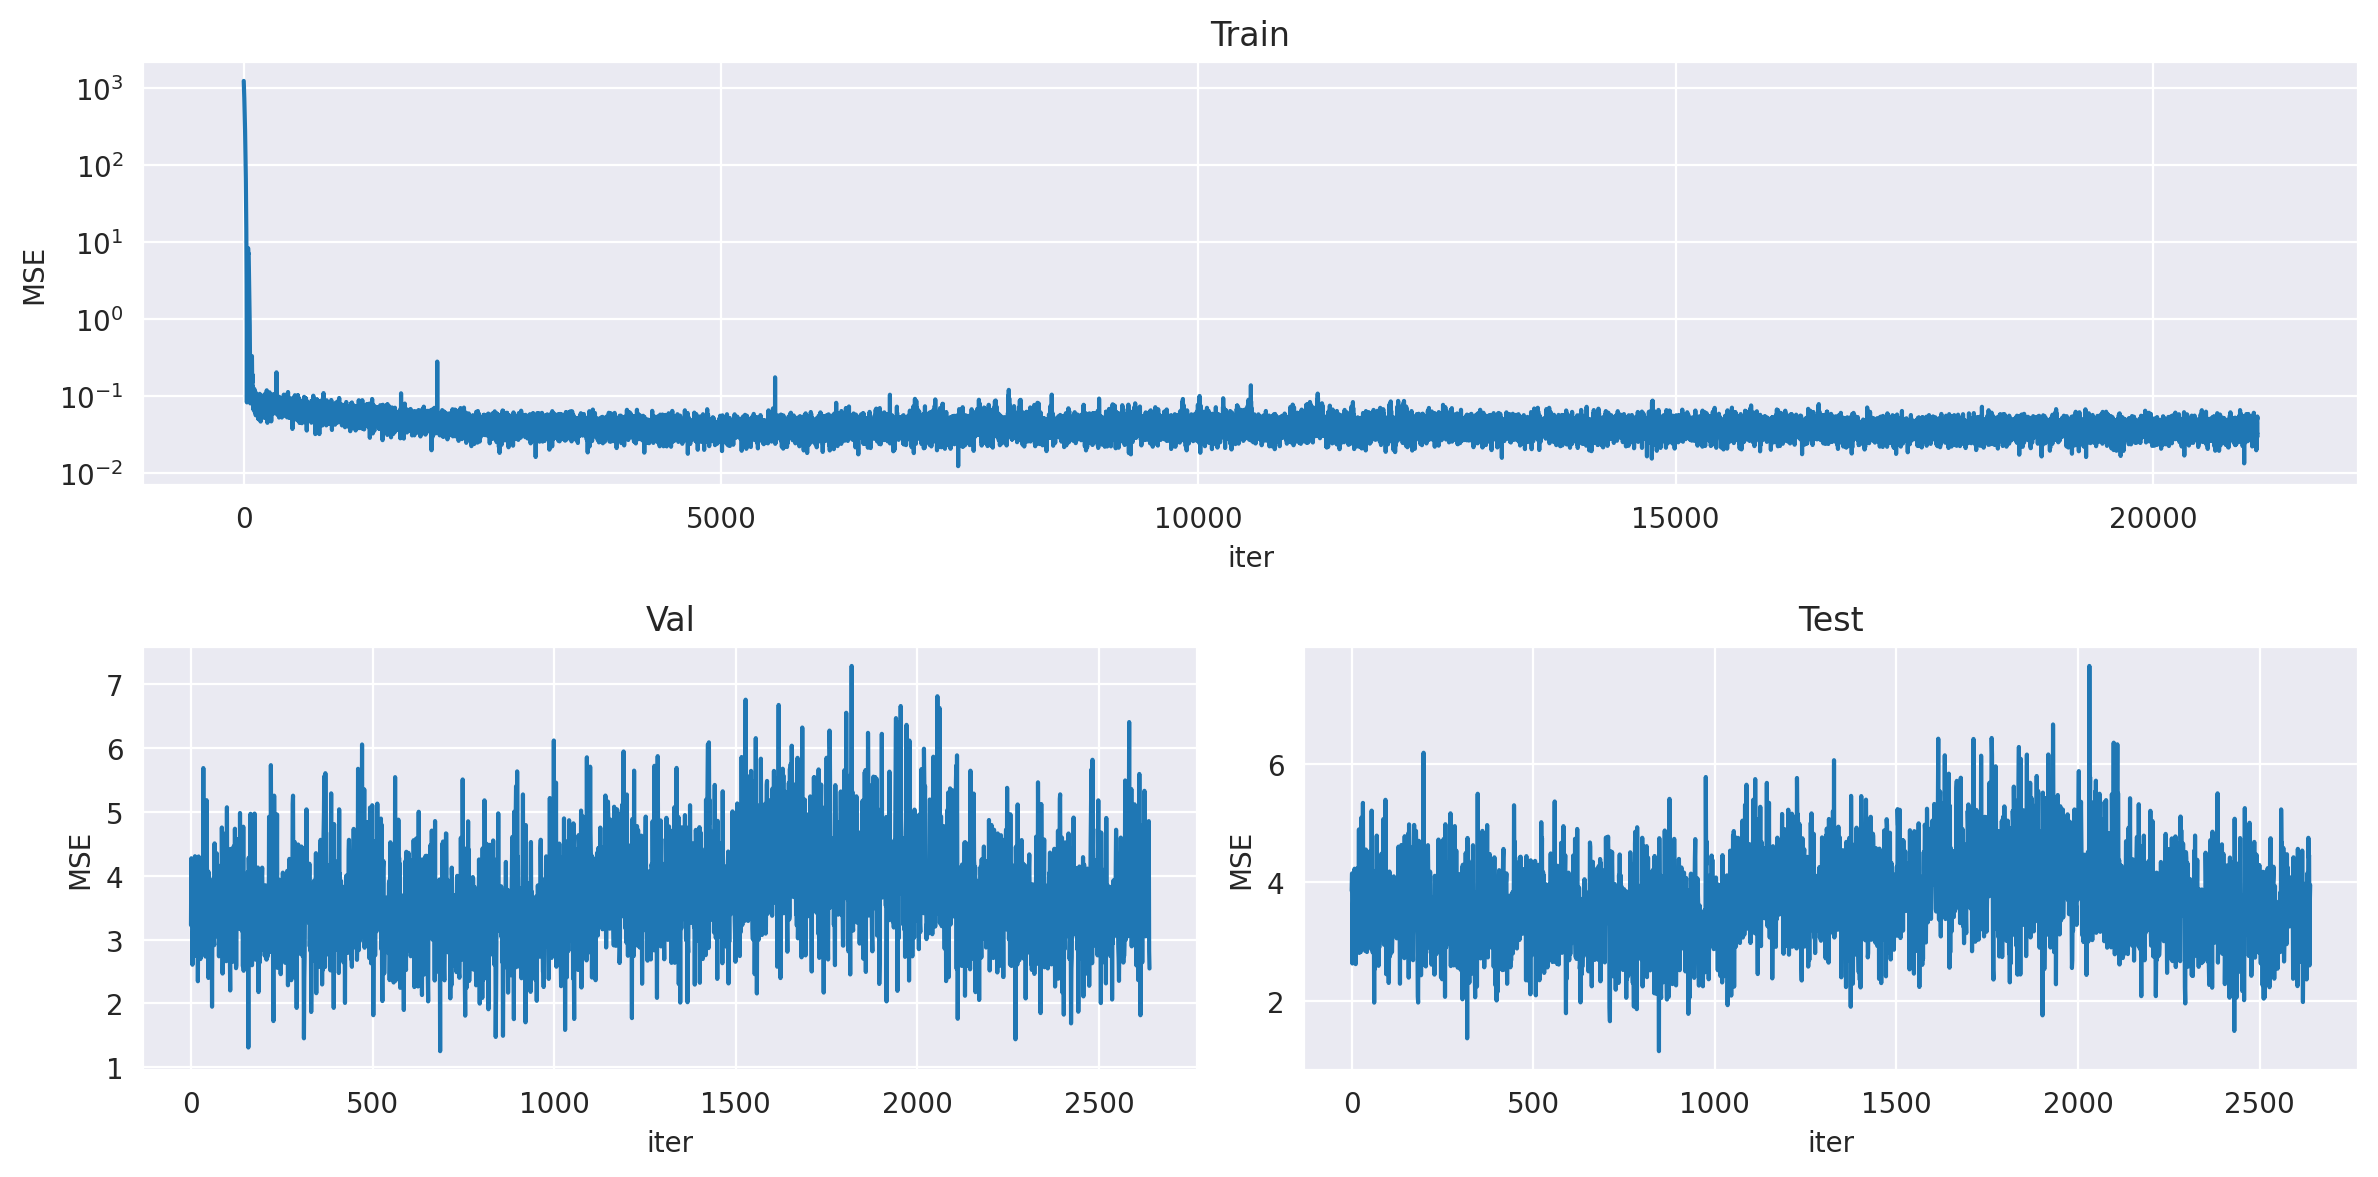

1.880618

In [180]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Усложним архитектуру добаим третий слой:
1. 2 слоя (128 нейронов) + (64 нейрона)
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.9264757633209229


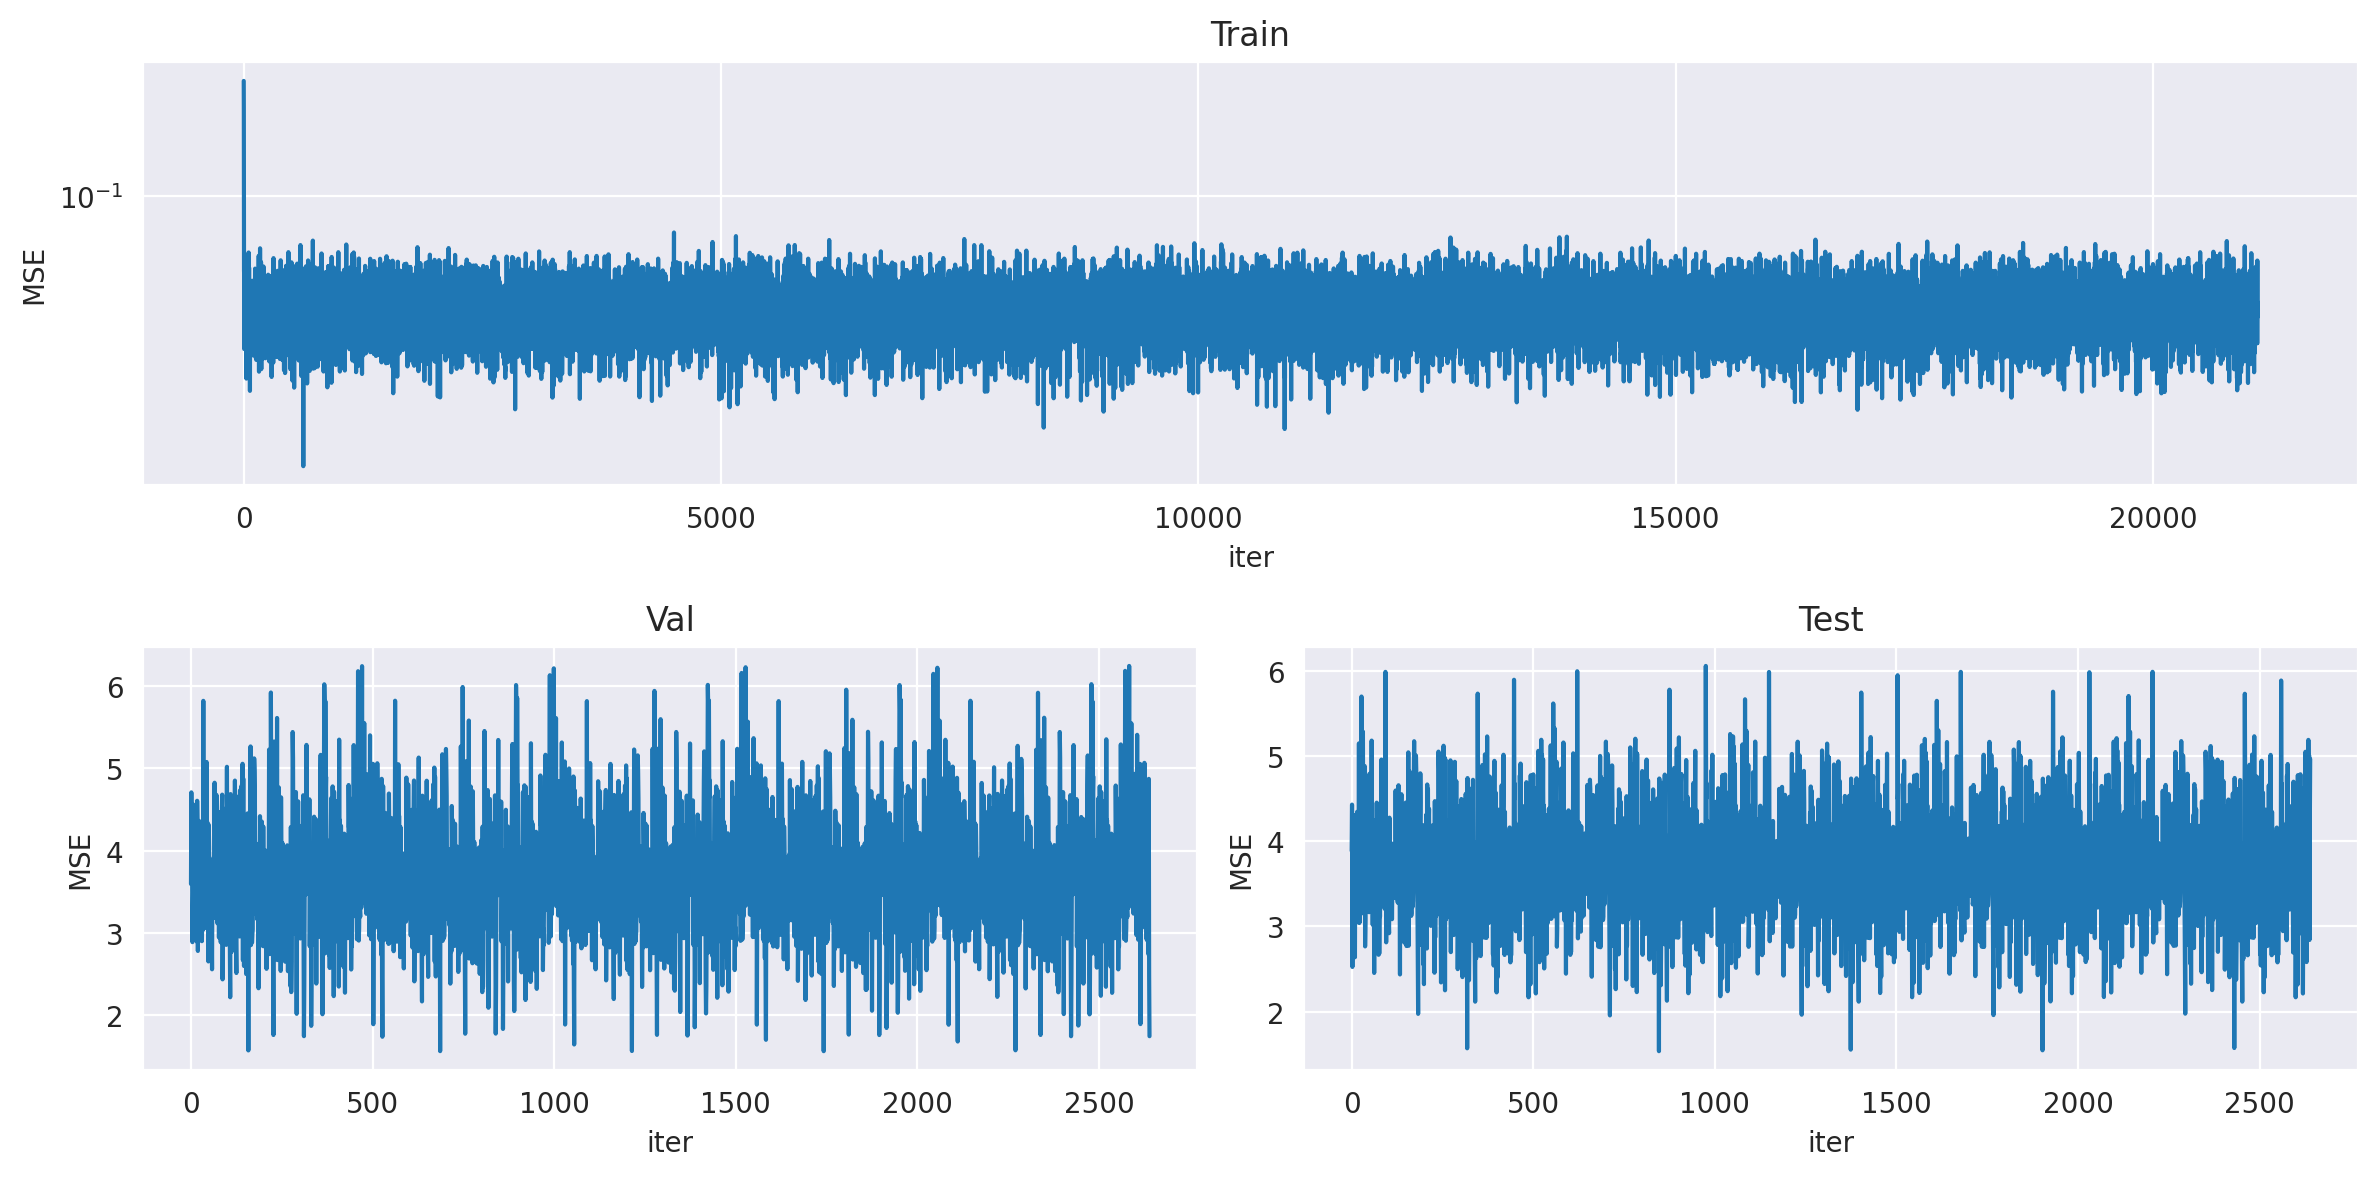

1.9264758

In [181]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Усложним архитектуру добаим BatchNorm:
1. 2 слоя (128 нейронов) + batchnorm + (64 нейрона)
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR


Epoch: 5
Test RMSE: 1.8017642498016357


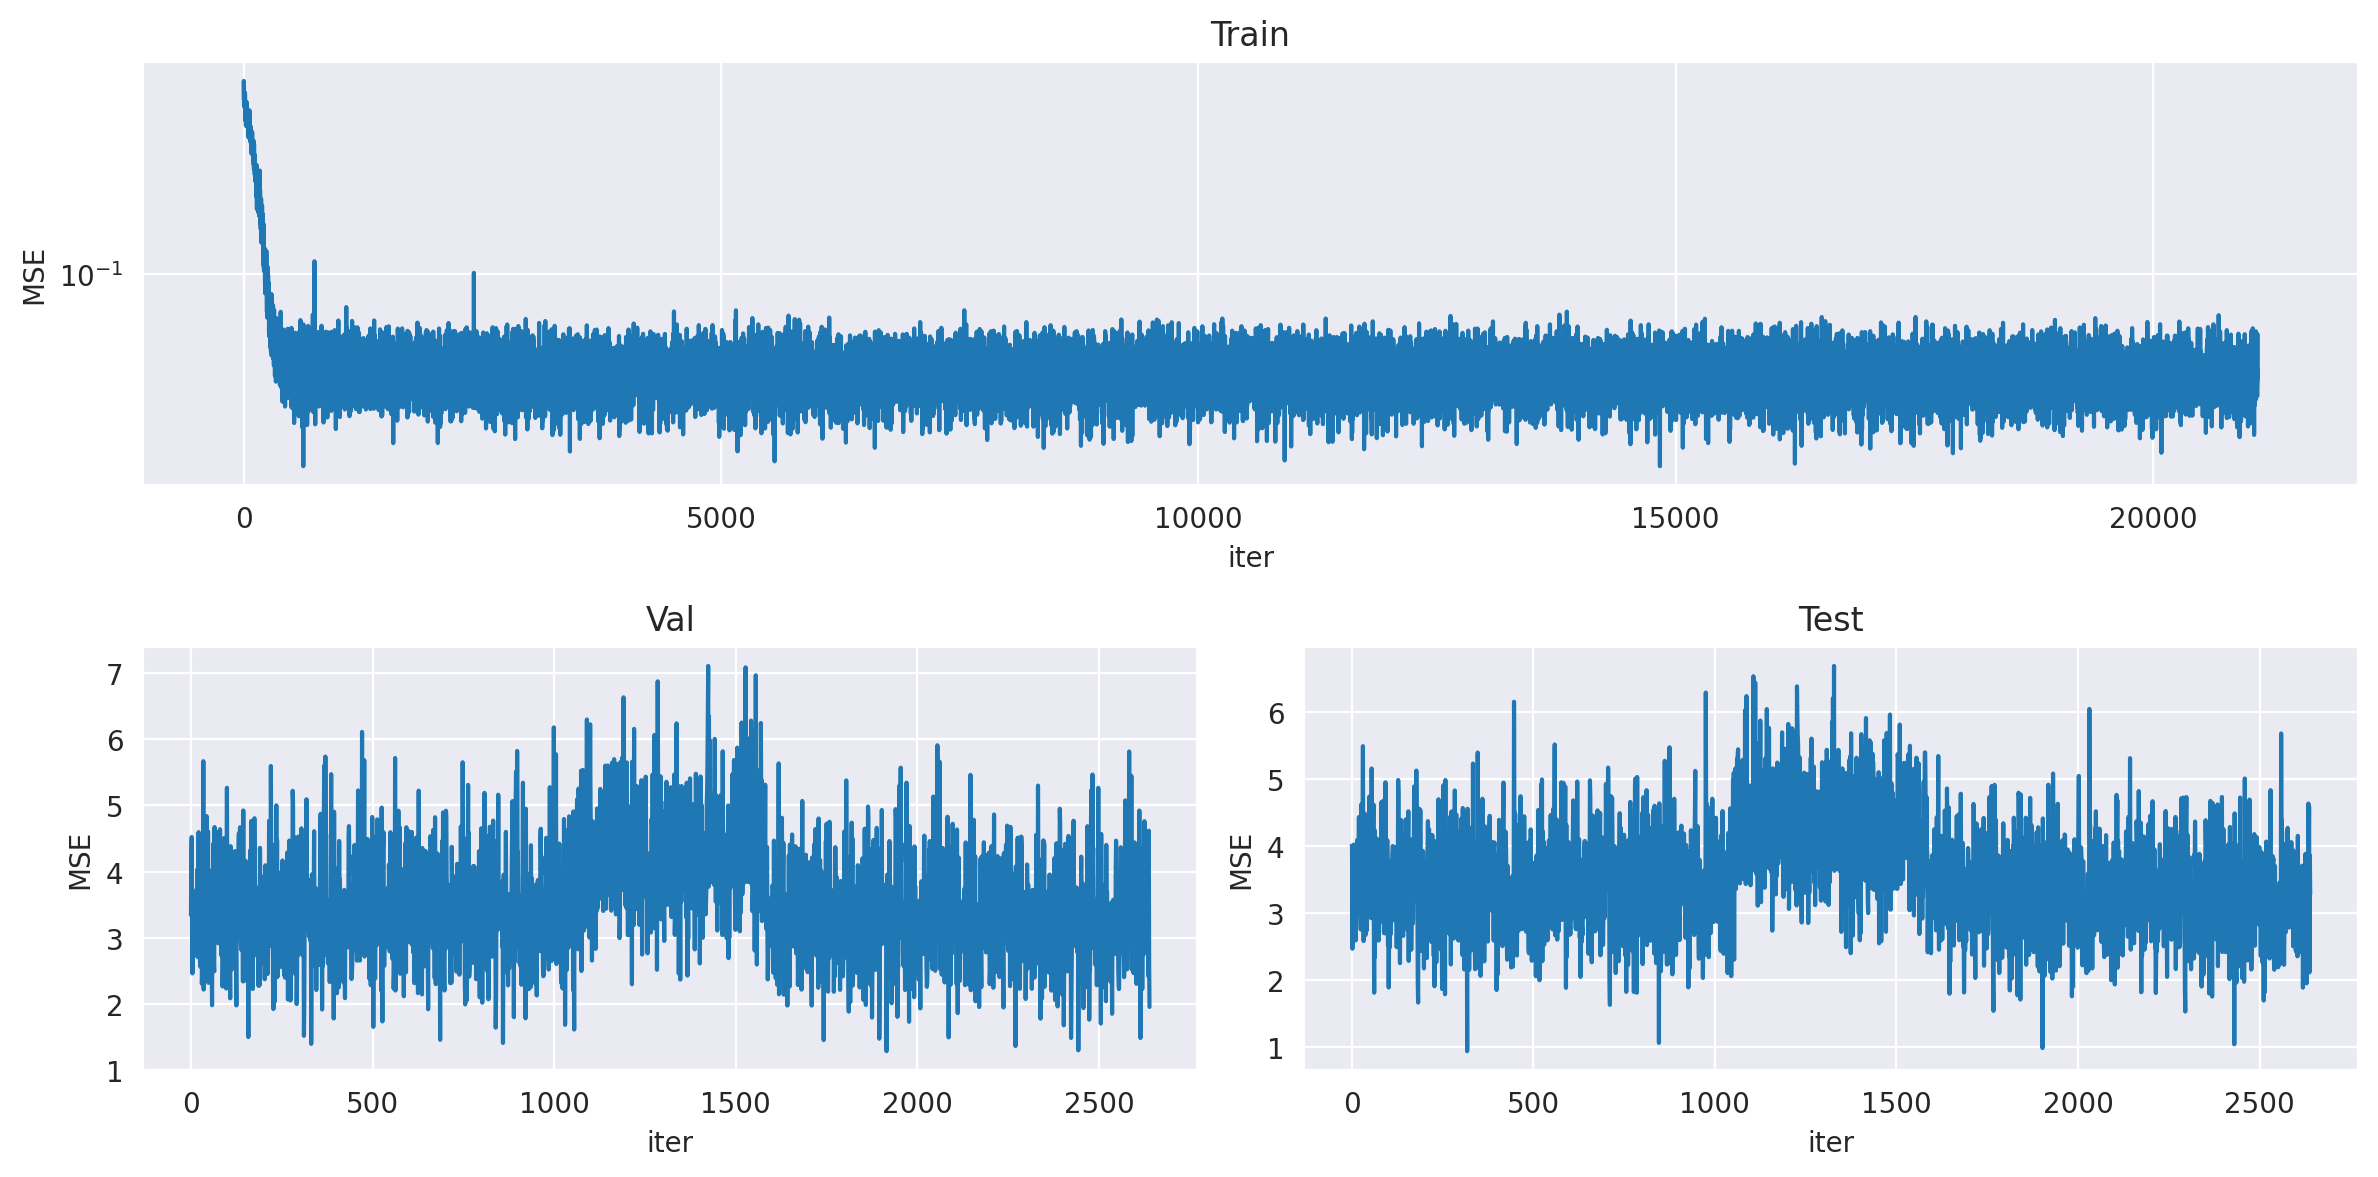

1.8017642

In [182]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.batchn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.batchn(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Усложним архитектуру добаим Dropout:
1. 2 слоя (128 нейронов) + batchnorm + (64 нейрона) + dropout(0.2)
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.8202952146530151


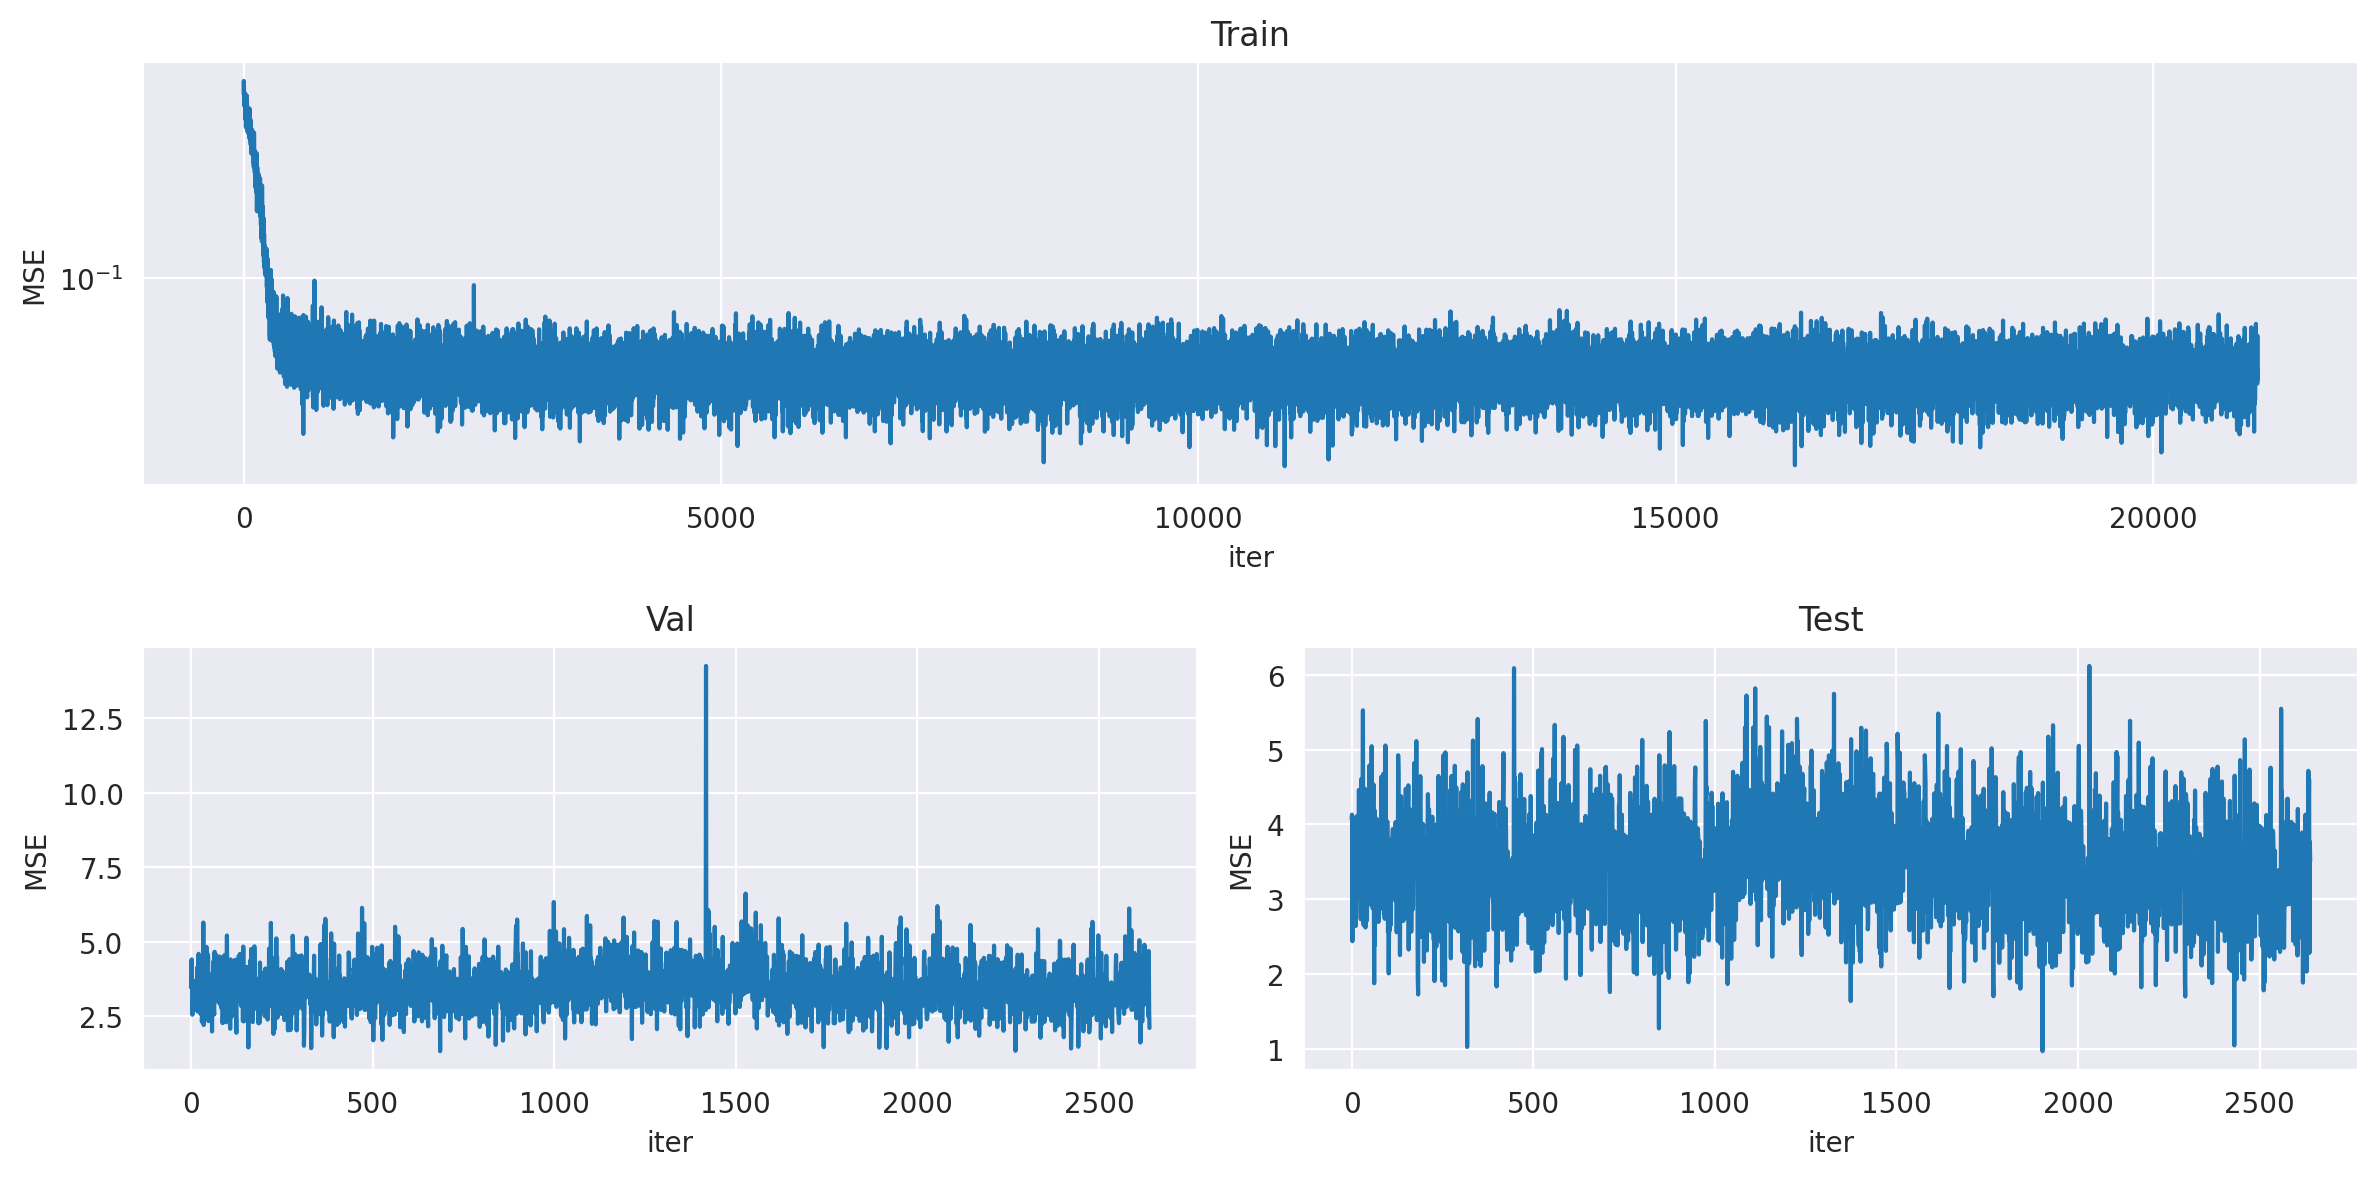

1.8202952

In [183]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.batchn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.batchn(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop(x)
        x = self.fc3(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

#### Подберем гиперпарметры по логарифмической сетке:
Определим оптимальный:
1. learning rate
2. weight decay

In [184]:
rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
decays = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [185]:
losses = []
for lr in rates:
    model = TMDB(X_train.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
    criterion = F.mse_loss

    config_loss = fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler, verbose = False)
    losses.append(config_loss)
    clear_output()

In [186]:
best_lr = rates[np.argmin(losses)]
print(f'Best learning rate: {best_lr}')

Best learning rate: 0.001


In [ ]:
losses = []
for decay in decays:
    model = TMDB(X_train.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
    criterion = F.mse_loss

    config_loss = fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler, verbose = False)
    losses.append(config_loss)
    clear_output

In [ ]:
best_decay = decays[np.argmin(losses)]
print(f'Best weight decay: {best_decay}')

Финальная модель:
1. Берем лучшие гипер-параметры:
2. Обчучаем модель на всех данных
3. Смотрим на качество

In [ ]:
seed_everything(42)

y = norm_data['vote_average']
X = norm_data.drop(columns=['vote_average'], axis=1)

X_train, X_val, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target_scaler = MinMaxSeries()
target_scaler.fit(y_train)

y_train = target_scaler.transform(y_train)
y_test = target_scaler.transform(y_test)

train_set = PandasDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, worker_init_fn=42, batch_size=64)

test_set = PandasDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, worker_init_fn=42, batch_size=64)

In [ ]:
model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

train_loss_history, test_loss_history = [], []

for epoch in range(5):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate(model, test_loader, criterion, device, 'test', target_scaler)

    train_loss_history += train_loss
    test_loss_history += test_loss
    scheduler.step()

    rmse = np.sqrt(np.mean(test_loss))
    print(f'Epoch: {epoch+1}')
    print(f'Test RMSE: {rmse}')

___